## 翻译任务隐藏状态参数可视化分析

#### 用于处理数据的类

In [1]:
import os
import json
import numpy as np
translator_hid_state_data_path = "./datas/translator"
class HidDataFetch():
    def __init__(self, hid_datas_path) -> None:
        self.hid_datas_path = hid_datas_path
        self.dialogues_num = self.count_dirs(self.hid_datas_path)
        print("dialogues_num:", self.dialogues_num)
        self.dialogues = []
        self.tag_list = []
        self.datas = []
        self.fetch_all_dialogues()
        self.init_tags()
        # self.fetch_all_datas()

    # 将所有dialogue.txt读取整合
    def fetch_all_dialogues(self):
        for i in range(self.dialogues_num):
            self.dialogues.append(self.load_dialogue_by_index(i))
    # 将所有隐藏状态参数读取整合
    def fetch_all_datas(self):
        for i in range(self.dialogues_num):
            self.datas.append(self.load_data_by_index(i))

    # 读取对应index的dialogue.txt
    def load_dialogue_by_index(self, index):
        with open(self.hid_datas_path + "/" + str(index) + "/dialogue.txt", "r", encoding="utf-8") as f:
            dialogue = json.load(f)

    # 提取出所有的tag
    def init_tags(self):
        for diagolue in self.dialogues:
            self.tag_list.append(diagolue['tag'])

    # 统计文件夹中下有多少文件和文件夹
    def count_dirs(self, path):
        return len(os.listdir(path))
    
    # 从硬盘中读取对应的dialogue.txt
    def load_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        hid_data_path = os.path.join(self.hid_datas_path, str(index), 'dialogue.txt')
        # print(hid_data_path)
        hid_data = {}
        with open(hid_data_path, 'r', encoding='utf-8') as f:
            hid_data = json.load(f)
        return hid_data
    
    # 获取某index对应的完整的dialogue.txt
    def fetch_by_index(self, index):
        return self.dialogues[index]
    
    # 获取某index的tag
    def fetch_tag_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['tag']
    
    # 获取某index对应的完整的对话内容
    def fetch_dialogue_by_index(self, index):
        if index >= self.dialogues_num:
            print("index out of range")
            return None
        return self.dialogues[index]['dialogues']

    # 获取符合某个tag的所有index
    def fetch_index_list_by_tag(self, tag):
        return [index for index in range(self.dialogues_num) if self.dialogues[index]['tag'] == tag]

    # 获取某个index下的所有data
    def load_data_by_index(self, index):
        data_dir_path = os.path.join(self.hid_datas_path, str(index))
        datas = []
        for file in sorted(os.listdir(data_dir_path)):
            if file.endswith(".npz"):
                data_path = os.path.join(data_dir_path, file)
                data_f = np.load(data_path)
                datas.append(np.array(list(data_f.values())))
                data_f.close()
        return datas
    
    # 获取user输入文本开始对应的index
    def get_use_text_index_by_index(self, index):
        user_index_list = [index for index, element in enumerate(self.load_data_by_index(index)) if element.shape[1] > 1]
        return user_index_list
        
        



#### 加载数据

In [2]:
data_fetcher = HidDataFetch(translator_hid_state_data_path)

dialogues_num: 1034


In [3]:
tag_wrong_trans_index_list = data_fetcher.fetch_index_list_by_tag("1")
tag_correct_trans_index_list = data_fetcher.fetch_index_list_by_tag("0")
print(f"翻译有问题的情况有{len(tag_wrong_trans_index_list)}个\n翻译正确的情况有{len(tag_correct_trans_index_list)}个")

翻译有问题的情况有182个
翻译正确的情况有844个


In [4]:
## 注意，有不少情况是大模型在尝试回答原文的问题，导致没能够完成翻译任务，所以先统计原文是问题的情况
ori_question_index_list = [index for index in range(data_fetcher.dialogues_num) if data_fetcher.dialogues[index]['dialogues'][-2]['content'][-2] == "?"]
print(f"原文是问题的情况有{len(ori_question_index_list)}个")

原文是问题的情况有127个


In [5]:
no_qes_and_wrong_trans_index_list = [index for index in tag_wrong_trans_index_list if index not in ori_question_index_list]
print(f"翻译有错误，原文不是问题的情况有{len(no_qes_and_wrong_trans_index_list)}个")

翻译有错误，原文不是问题的情况有100个


In [6]:
h1_no_qes_and_wrong_trans_index_list = no_qes_and_wrong_trans_index_list[:100]
h1_tag_correct_trans_index_list = tag_correct_trans_index_list[:100]

#### 选取一个正例和一个反例

In [7]:
print(f"first 5 obey:{str(tag_correct_trans_index_list[:5])}")
print(f"first 5 disobey:{str(no_qes_and_wrong_trans_index_list[:5])}")

first 5 obey:[0, 2, 3, 5, 6]
first 5 disobey:[4, 11, 37, 38, 51]


In [8]:
data_fetcher.get_use_text_index_by_index(6)

[0, 15]

In [9]:
data_fetcher.fetch_dialogue_by_index(51)

[{'role': 'user',
  'content': "Your role is that of a language converter. Take the English sentence 'Sustainable practices are becoming increasingly important in manufacturing' and give me the Chinese equivalent."},
 {'role': 'assistant', 'content': '\n 可持续的实践在制造业中变得越来越重要'},
 {'role': 'user', 'content': 'This is a difficult math problem.\n'},
 {'role': 'assistant',
  'content': "\n I\\'m sorry, but I am not able to solve math problems. I am a language model designed to assist with general knowledge and information, as well as provide definitions for words and phrases. If you have a specific math problem that you would like help with, it would be best to seek assistance from a qualified math teacher or tutor."}]

In [11]:
data_fetcher.get

AttributeError: 'HidDataFetch' object has no attribute 'get'

In [10]:

data_fetcher.load_data_by_index(6)[data_fetcher.get_use_text_index_by_index(6)[1]+1].shape

(29, 1, 1, 4096)

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_data(i):
    second_assistant_start_index = data_fetcher.get_use_text_index_by_index(i)[1]+1
    tmp_data = data_fetcher.load_data_by_index(i)[second_assistant_start_index].reshape(29, 4096)
    tmp_label = str(data_fetcher.fetch_tag_by_index(i))
    return i, tmp_data, tmp_label  # 返回索引和数据

# 初始化列表
datas = [None] * len(data_fetcher.dialogues)
labels = [None] * len(data_fetcher.dialogues)
count = 0
with ThreadPoolExecutor(max_workers=200) as executor:
    futures = [executor.submit(process_data, i) for i in range(len(data_fetcher.dialogues))]

    for future in as_completed(futures):
        i, tmp_data, tmp_label = future.result()
        datas[i] = tmp_data  # 使用索引直接插入到正确的位置
        labels[i] = tmp_label
        count = count+1
        print(count)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:
len(datas[0])

29

In [19]:
datas_layer29 = np.array([data[28] for data in datas])

str

In [67]:
labels_int = np.array([int(y) if y=='0' or y=='1' else 0  for y in labels])

In [47]:
len(labels_int)

1034

In [49]:
labels_int

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,


#### 尝试t-SNE降维到三维

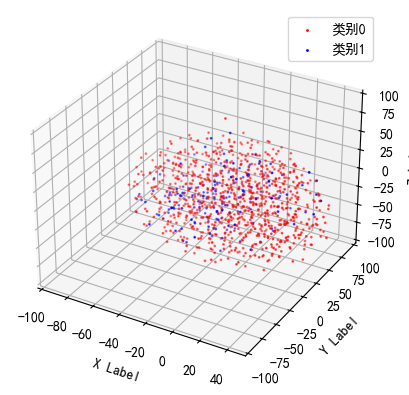

In [74]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif']=['SimHei'] # 设置字体为黑体，解决Matplotlib中文乱码问题

plt.rcParams['axes.unicode_minus']=False # 解决Matplotlib坐标轴负号'-'显示为方块的问题

# 假设您的输入数据是一个名为data的numpy数组，形状是(29, 4096)
# 假设labels是标签数组

# 应用t-SNE降维到三维
tsne = TSNE(n_components=3, random_state=42)
data_tsne = tsne.fit_transform(np.array(datas_layer29))

# 可视化
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 假设您有两个标签类别，用0和1表示
ax.scatter(data_tsne[labels_int == 0, 0], data_tsne[labels_int == 0, 1], data_tsne[labels_int == 0, 2], c='r', s=1,label='类别0')
ax.scatter(data_tsne[labels_int == 1, 0], data_tsne[labels_int == 1, 1], data_tsne[labels_int == 1, 2], c='b', s=1,label='类别1')

plt.xlim(-100, 50)
plt.ylim(-100, 100)
ax.set_zlim(-100, 100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend()

plt.show()

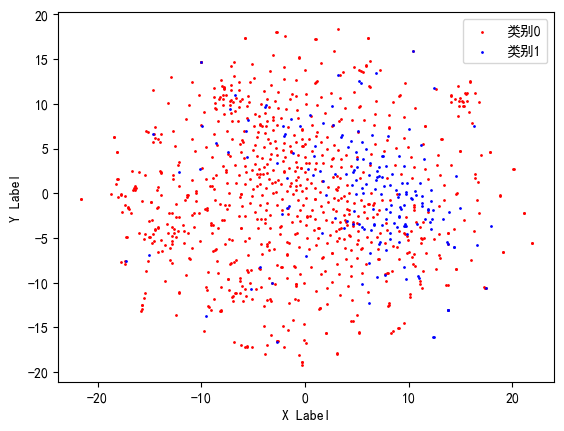

In [75]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# 应用t-SNE降维到二维
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(np.array(datas_layer29))

# 可视化
fig, ax = plt.subplots()

# 假设您有两个标签类别，用0和1表示
ax.scatter(data_tsne[labels_int == 0, 0], data_tsne[labels_int == 0, 1], c='r', s=1, label='类别0')
ax.scatter(data_tsne[labels_int == 1, 0], data_tsne[labels_int == 1, 1], c='b', s=1, label='类别1')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.legend()

plt.show()

In [66]:
type(labels_int)

list

In [64]:
data_tsne[labels_int == 0, 0]

array([], shape=(0, 1034, 3), dtype=float32)